- [Rossi](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html)
- [scikit-survival](https://scikit-survival.readthedocs.io/en/stable/)
- https://www.kaggle.com/code/gunesevitan/survival-analysis
- https://www.kaggle.com/code/sonalisingh1411/statistical-analysis-eda-survival-prediction
- https://www.kaggle.com/code/brianfitzgibbon0/kaplan-meier-eda-modelling-no-leakage-f1-84
- https://www.kaggle.com/code/sryo188558/cox-proportional-hazard-model
- https://www.kaggle.com/code/bryanb/survival-analysis-with-cox-model-implementation
- https://scikit-learn.org/stable/user_guide.html

# Survival regression

Often we have additional data aside from the duration that we want to use. The technique is called survival regression – the name implies we regress covariates (e.g., age, country, etc.) against another variable – in this case durations. Similar to the logic in the first part of this tutorial, we cannot use traditional methods like linear regression because of censoring.

There are a few popular models in survival regression: Cox’s model, accelerated failure models, and Aalen’s additive model. All models attempt to represent the hazard rate $h(t|x)$ as a function of $t$ and some covariates $x$. We explore these models next.

In [86]:
%matplotlib inline

# Load the necessary libraries
import pretty_errors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

## The dataset for regression

The dataset required for survival regression must be in the format of a Pandas DataFrame. Each row of the DataFrame represents an observation. There should be a column denoting the durations of the observations. There may (or may not) be a column denoting the event status of each observation (1 if event occurred, 0 if censored). There are also the additional covariates you wish to regress against. Optionally, there could be columns in the DataFrame that are used for stratification, weights, and clusters which will be discussed later in this tutorial.

An example dataset we will use is the Rossi recidivism dataset, available in lifelines as `lifelines.datasets.load_rossi()`.

In [87]:
# Load the Rossi dataset
rossi = load_rossi()

rossi.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


A data frame with 432 observations on the following 9 variables.
* week: Week of first arrest after release, or censoring; all censored observations are censored at 52 weeks.
* arrest: 1 if arrested, 0 if not arrested.
* fin: Financial aid: 0=No, 1=Yes.
* age: Age in years at time of release.
* race: Black or other.
* wexp: Full-time work experience before incarceration: 0=No, 1=Yes.
* mar: marital status at time of release: married or not married.
* paro: Released on parole? 0=No, 1=Yes.
* prio: number of convictions prior to current incarceration.

In [88]:
rossi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   week    432 non-null    int64
 1   arrest  432 non-null    int64
 2   fin     432 non-null    int64
 3   age     432 non-null    int64
 4   race    432 non-null    int64
 5   wexp    432 non-null    int64
 6   mar     432 non-null    int64
 7   paro    432 non-null    int64
 8   prio    432 non-null    int64
dtypes: int64(9)
memory usage: 30.5 KB


## Kaplan-Meier

`T` is an array of durations, `E` is a either boolean or binary array representing whether the “death” was observed or not (alternatively an individual can be censored). We will fit a Kaplan Meier model to this, implemented as `KaplanMeierFitter`:

In [89]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
copy_rossi = rossi.copy()
copy_rossi['arrest'] = copy_rossi['arrest'].astype(bool)
T = copy_rossi['week']
E = copy_rossi['arrest']
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 432 total observations, 318 right-censored observations>

After calling the `lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter.fit()` method, we have access to new properties like `lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter.survival_function_` and methods like `lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter.plot()`. The latter is a wrapper around Panda’s internal plotting library.

<AxesSubplot:xlabel='timeline'>

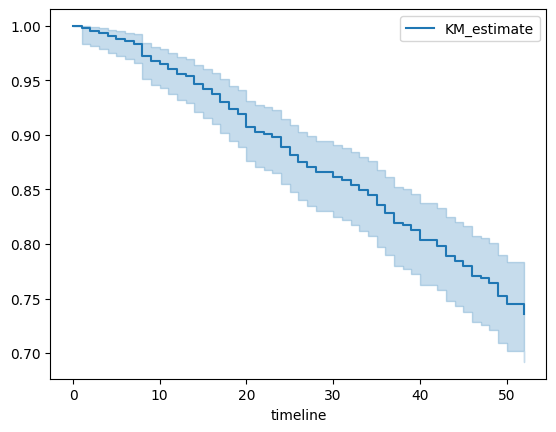

In [90]:
kmf.survival_function_
kmf.cumulative_density_
kmf.plot_survival_function()

<AxesSubplot:xlabel='timeline'>

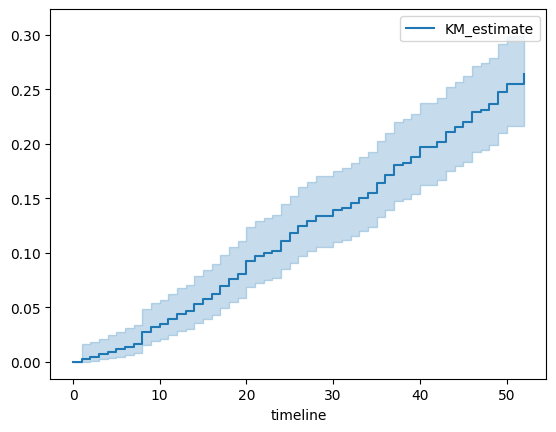

In [91]:
kmf.plot_cumulative_density()

By specifying the `timeline` keyword argument in `lifelines.fitters.kaplan_meier_fitter.KaplanMeierFitter.fit`, we can change how the above models are indexed:

In [92]:
kmf.fit(T, event_observed=E, timeline=np.linspace(0, 52, 100))

kmf.survival_function_   # index is now the same as range(0, 100, 2)
kmf.confidence_interval_ # index is now the same as range(0, 100, 2)

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.000000,1.000000,1.000000
0.525253,1.000000,1.000000
1.050505,0.983683,0.999674
1.575758,0.983683,0.999674
2.101010,0.981617,0.998840
...,...,...
49.898990,0.708792,0.790314
50.424242,0.701526,0.783787
50.949495,0.701526,0.783787
51.474747,0.701526,0.783787


A useful summary stat is the median survival time, which represents when 50% of the population has died:

In [93]:
from lifelines.utils import median_survival_times

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

Instead of the Kaplan-Meier estimator, you may be interested in a parametric model. lifelines has builtin parametric models. For example, Weibull, Log-Normal, Log-Logistic, and more.

c:\Users\omarc\AppData\Local\Programs\Python\Python39\lib\site-packages\lifelines\fitters\__init__.py:1000: ApproximationWarning: 
The Hessian for PiecewiseExponentialFitter's fit was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too. Perform plots of the cumulative hazard to help understand the latter's bias.

  warnings.warn(warning_text, exceptions.ApproximationWarning)


<AxesSubplot:>

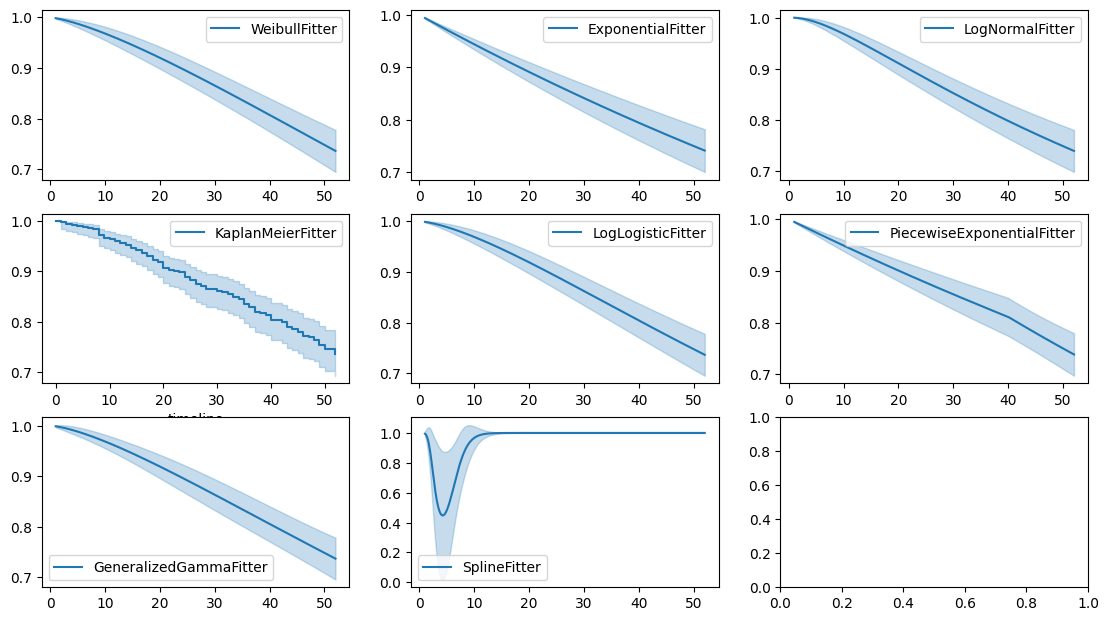

In [94]:
from lifelines import *

fig, axes = plt.subplots(3, 3, figsize=(13.5, 7.5))

kmf = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter')
wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
ggf = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
sf = SplineFitter(np.percentile(T.loc[E.astype(bool)], [0, 50, 100])).fit(T, E, label='SplineFitter')

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
ggf.plot_survival_function(ax=axes[2][0])
sf.plot_survival_function(ax=axes[2][1])

## Multiple Groups

      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


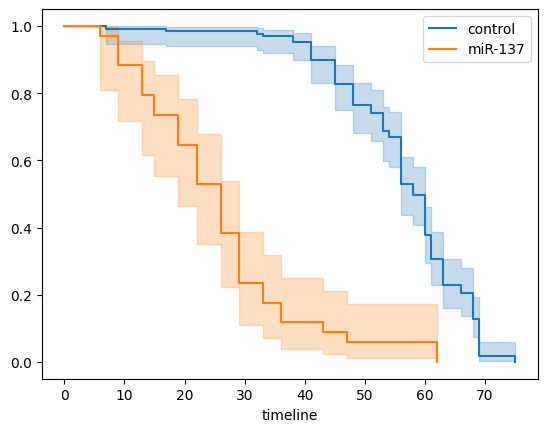

In [95]:
from lifelines.datasets import load_waltons
waltons_df = load_waltons() # returns a Pandas DataFrame

print(waltons_df.head())

waltons_T = waltons_df['T']
waltons_E = waltons_df['E']
groups = waltons_df['group']
ix = (groups == 'miR-137')

kmf.fit(waltons_T[~ix], waltons_E[~ix], label='control')
ax = kmf.plot_survival_function()

kmf.fit(waltons_T[ix], waltons_E[ix], label='miR-137')
ax = kmf.plot_survival_function(ax=ax)

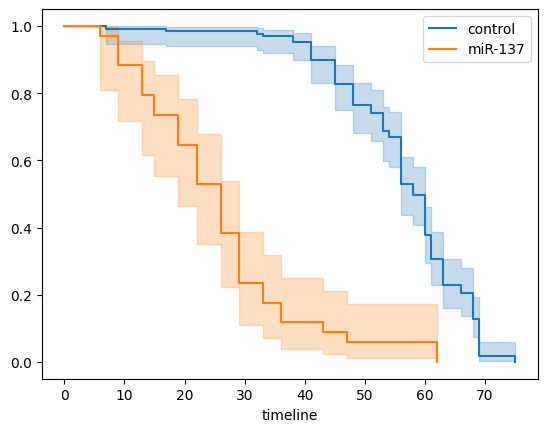

In [96]:
ax = plt.subplot(111)

kmf = KaplanMeierFitter()

for name, grouped_df in waltons_df.groupby('group'):
    kmf.fit(grouped_df["T"], grouped_df["E"], label=name)
    kmf.plot_survival_function(ax=ax)

The DataFrame `rossi` contains 432 observations. The `week` column is the duration, the `arrest` column denotes if the event (a re-arrest) occurred, and the other columns represent variables we wish to regress against.

## Cox's proportional hazard model

The idea behind Cox’s proportional hazard model is that the log-hazard of an individual is a linear function of their covariates and a population-level baseline hazard that changes over time. Mathematically:

$$\underbrace{h(t | x)}_{\text{hazard}} = \overbrace{b_0(t)}^{\text{baseline hazard}} \underbrace{\exp \overbrace{\left(\sum_{i=1}^n b_i (x_i - \overline{x_i})\right)}^{\text{log-partial hazard}}}_ {\text{partial hazard}}
$$

where $h_0(t)$ is the baseline hazard, $b_0(t)$ is the baseline cumulative hazard, and $b_j$ is the regression coefficient for the $j$'th covariate. The baseline hazard is a function of time that is constant across all individuals. The baseline hazard is estimated from the data using a non-parametric method called Nelson-Aalen’s estimator. The baseline cumulative hazard is the integral of the baseline hazard. The regression coefficients are estimated using maximum likelihood.

Note a few behaviors about this model: the only time component is in the baseline hazard, $b_0(t)$. In the above equation, the partial hazard is a time-invariant scalar factor that only increases or decreases the baseline hazard. Thus changes in covariates will only inflate or deflate the baseline hazard.

In other regression models, a column of 1s might be added that represents that intercept or baseline. This is not necessary in the Cox model. In fact, there is no intercept in the Cox model - the baseline hazard represents this. *lifelines* will throw warnings and may experience convergence errors if a column of 1s is present in your dataset or formula.

## Fitting the regression

The implementation of the Cox model in *lifelines* is under `CoxPHFitter`. We fit the model to the dataset using `fit()`. It has a `print_summary()` function that prints a tabular view of coefficients and related stats.

In [97]:
# Fit a Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest')
# cph.fit(rossi, duration_col='week', event_col='arrest', formula="fin + wexp + age * prio")

# Compute the hazard ratios and their confidence intervals
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2023-03-13 06:13:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.75            -0.00                 0.47                 1.00
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.37       0.31            -0.29             0.92                 0.75                 2.50
wexp       -0.15       0.86       0.21            -0.57             0.27                 0.57                 1.30
mar        -0.43       0.65       0.38            -1.18             0.31                 0.31                 1.37
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.10       0.03             0.04             0.15                 1.04                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -1.98   0.05       4.40
age           0.00 -2.61   0.01       6.79
race          0.00  1.02   0.31       1.70
wexp          0.00 -0.71   0.48       1.06
mar           0.00 -1.14   0.26       1.97
paro          0.00 -0.43   0.66       0.59
prio          0.00  3.19 <0.005       9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

## Interpretation

To access the coefficients and the baseline hazard directly, you can use `params_` and `baseline_hazard_` respectively. Taking a look at these coefficients for a moment, `prio` (the number of prior arrests) has a coefficient of about 0.09. Thus, a one unit increase in `prio` means the the baseline hazard will increase by a factor of $\exp{(0.09)} = 1.10$ - about a 10% increase. Recall, in the Cox proportional hazard model, a higher hazard means more at risk of the event occurring. The value $\exp{(0.09)}$ is called the *hazard ratio*, a name that will be clear with another example.

Consider the coefficient of `mar` (whether the subject is married or not). The values in the column are binary: 0 or 1, representing either  unmarried or married. The value of the coefficient associated with `mar`, $\exp{(-.43)}$, is the value of ratio of *hazards* associated with being married, that is:

$$\exp(-0.43) = \frac{\text{hazard of married subjects at time $t$}}{\text{hazard of unmarried subjects at time $t$}}$$

Note that left-hand side is a constant (specifically, it's independent of time, $t$), but the right-hand side has two factors that may vary with time. The *proportional hazard assumption* is that relationship is true. That is, hazards can change over time, but their ratio between levels remains a constant. Later we will deal with checking this assumption. However, in reality, it's very common for the hazard ratio to change over the study duration. The hazard ratio then has the interpretation of some sort of weighted average of period-specific hazard ratios. As a result, the hazard ratio may critically depend on the duration of the follow-up.

## Convergence

Fitting the Cox model to the data involves using iterative methods. *lifelines* takes extra effort to help with convergence, so please be attentive to any warnings that appear. Fixing any warnings will generally help convergence and decrease the number of iterative steps required. If you wish to see more information during fitting, there is a `show_progress` parameter in `fit()` function.

After fitting, the value of the maximum log-likelihood this available using `log_likelihood_`. The variance matrix of the coefficients is available under `variance_matrix_`.

## Goodness of fit

After fitting, you may want to know how "good" of a fit your model was to the data. A few methods the author has found useful is to
- inspect the survival probability calibration plot
- look at the concordance-index, available as `concordance_index_` or in the `print_summary` as a measure of predictive accuracy.
- look at the log-likelihood test result in the `print_summary()` or `log_likelihood_ratio_test()`
- check the proportional hazards assumption with the `check_assumptions()` method. See section later on this page for more details.

## Prediction

After fitting, you can use use the suite of prediction methods: `predict_partial_hazard()`, `predict_survival_function()`, and others.

In [98]:
X = rossi

cph.predict_survival_function(X)
cph.predict_median(X)
cph.predict_partial_hazard(X)

0      1.219126
1      3.230250
2      3.031058
3      0.487712
4      1.214025
         ...   
427    0.416973
428    1.517713
429    0.579426
430    0.935629
431    0.710516
Length: 432, dtype: float64

## Penalties and sparse regression

It's possible to add a penalizer term to the Cox regression as well. One can use these to i) stabilize the coefficients, ii) shrink the estimates to 0, iii) encourages a Bayesian viewpoint, and iv) create sparse coefficients. All regression models, including the Cox model, include both an L1 and L2 penalty:

$$\frac{1}{2} \text{penalizer} \left((1-\text{l1-ratio}) \cdot ||\beta||_2^2 + \text{l1-ratio} \cdot ||\beta||_1\right)$$

It's not clear from the above, but intercept (when applicable) are not penalized. 

Instead of a float, an *array* can be provided that is the same size as the number of penalized parameters. The values in the array are specific penalty coefficients for each covariate. This is useful for more complicated covariate structure.

To use this in *lifelines*, both the `penalizer` and `l1_ratio` can be specified in the class creation:

In [99]:
# variable `fin` is the treatment of interest so don't penalize it at all
penalty = np.array([0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

cph_sparse = CoxPHFitter(penalizer=penalty) # sparse solutions,
cph_sparse.fit(rossi, 'week', 'arrest')
cph_sparse.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                penalizer = [0.  0.5 0.5 0.5 0.5 0.5 0.5]
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -667.42
         time fit was run = 2023-03-13 06:13:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.69       0.19            -0.75            -0.00                 0.47                 1.00
age        -0.02       0.98       0.01            -0.03             0.00                 0.97                 1.00
race        0.09       1.10       0.17            -0.23             0.42                 0.79                 1.53
wexp       -0.15       0.86       0.11            -0.37             0.07                 0.69                 1.07
mar        -0.17       0.84       0.17            -0.51             0.17                 0.60                 1.18
paro       -0.04       0.96       0.11            -0.26             0.19                 0.77                 1.20
prio        0.04       1.04       0.02             0.00             0.07                 1.00                 1.08

            cmp to     z    p   -log2(p)
covariate                               
fin           0.00 -1.97 0.05       4.37
age           0.00 -1.75 0.08       3.64
race          0.00  0.56 0.57       0.80
wexp          0.00 -1.34 0.18       2.47
mar           0.00 -0.98 0.33       1.61
paro          0.00 -0.32 0.75       0.42
prio          0.00  2.00 0.05       4.45
---
Concordance = 0.63
Partial AIC = 1348.85
log-likelihood ratio test = 15.91 on 7 df
-log2(p) of ll-ratio test = 5.27

## Plotting the coefficients

With a fitted model, an alternative way to view the coefficients and their ranges is to use the `plot` method.

<AxesSubplot:xlabel='log(HR) (95% CI)'>

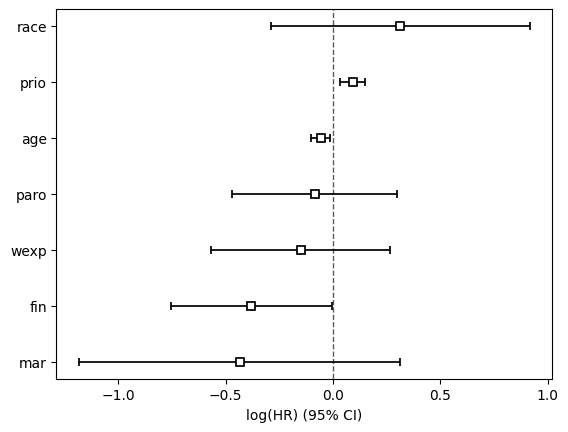

In [100]:
cph.plot()

<AxesSubplot:xlabel='log(HR) (95% CI)'>

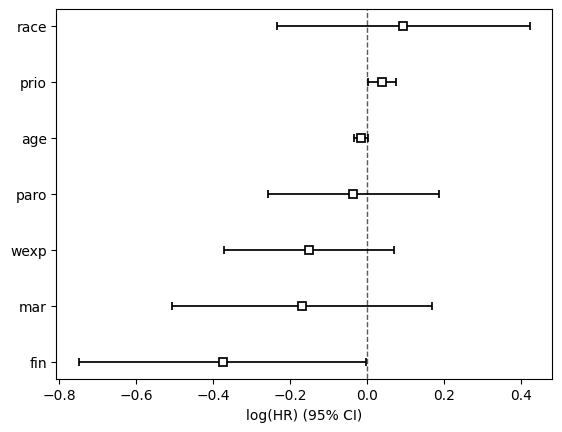

In [101]:
cph_sparse.plot()

## Plotting the effect of varying a covariate

After fitting, we can plot what the survival curves look like as we vary a single covariate while holding everything else equal. This is useful to understand the impact of a covariate, *given the model*. To do this, we use the `plot_partial_effects_on_outcome()` method and give it the covariate of interest, and the values to display.

<AxesSubplot:>

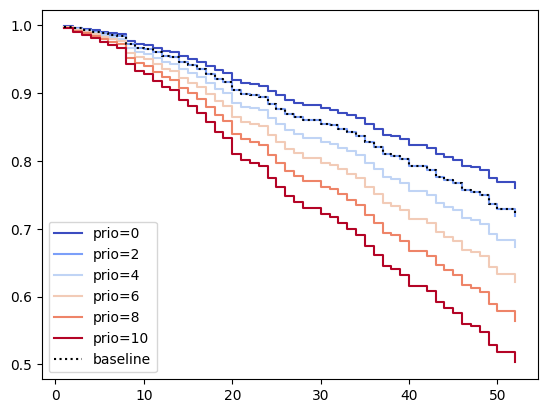

In [102]:
cph.plot_partial_effects_on_outcome(covariates='prio', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')

<AxesSubplot:>

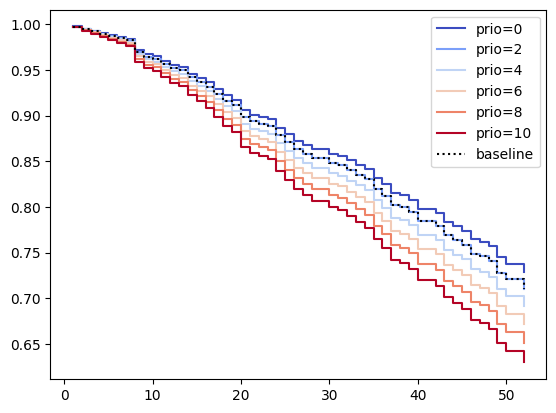

In [103]:
cph_sparse.plot_partial_effects_on_outcome(covariates='prio', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')

## Checking the proportional hazards assumption

To make proper inferences, we should ask if our Cox model is appropriate for our dataset. Recall from above that when using the Cox model, we are implicitly applying the proportional hazard assumption. We should ask, does our dataset obey this assumption?

`CoxPHFitter` has a `check_assumptions()` method that will output violations of the proportional hazard assumption. Suggestions are to look for ways to *stratify* a column, or use a time varying model. Checking assumptions like this is only necessary if your goal is inference or correlation. That is, you wish to understand the influence of a covariate on the survival duration & outcome. If your goal is prediction, checking model assumptions is less important since your goal is to maximize an accuracy metric, and not learn about *how* the model is making that prediction.

## Stratification

Sometimes one or more covariates may not obey the proportional hazard assumption. In this case, we can allow the covariate(s) to still be including in the model without estimating its effect. This is called stratification. At a high level, think of it as splitting the dataset into *m* smaller datasets, partitioned by the unique values of the stratifying covariate(s). Each dataset has its own baseline hazard (the non-parametric part of the model), but they all share the regression parameters (the parametric part of the model). Since covariates are the same within each dataset, there is no regression parameter for the covariates stratified on, hence they will not show up in the output. However there will be *m* baseline hazards under `baseline_cumulative_hazard_`. To specify variables to be used in stratification, we define them in the call to `fit()`.

In [104]:
cph_strata = CoxPHFitter()
cph_strata.fit(rossi, 'week', event_col='arrest', strata=['wexp'])
cph_strata.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                   strata = wexp
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -580.89
         time fit was run = 2023-03-13 06:13:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.76            -0.01                 0.47                 0.99
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.36       0.31            -0.30             0.91                 0.74                 2.49
mar        -0.45       0.64       0.38            -1.20             0.29                 0.30                 1.34
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.09       0.03             0.03             0.15                 1.04                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -1.99   0.05       4.42
age           0.00 -2.64   0.01       6.91
race          0.00  1.00   0.32       1.65
mar           0.00 -1.19   0.23       2.09
paro          0.00 -0.42   0.67       0.57
prio          0.00  3.16 <0.005       9.33
---
Concordance = 0.61
Partial AIC = 1173.77
log-likelihood ratio test = 23.77 on 6 df
-log2(p) of ll-ratio test = 10.77

## Weights & robust errors

Observations can come with weights, as well. These weights may be integer values representing some commonly occurring observation, or they may be float values representing some sampling weights (ex: inverse probability weights). In the `fit()` method, an kwarg is present for specifying which column in the DataFrame should be used as weights, ex: `CoxPHFitter(df, 'T', 'E', weights_col='weights')`.

When using sampling weights, it's correct to also change the standard error calculations. That is done by turning on the `robust` flag in `fit()`. Internally, `CoxPHFitter` will use the sandwich estimator to compute the errors.

In [105]:
df_weights = pd.DataFrame({
    'T': [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'E': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
    'weights': [1.1, 0.5, 2.0, 1.6, 1.2, 4.3, 1.4, 4.5, 3.0, 3.2, 0.4, 6.2],
    'month': [10, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'age': [4, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
})

cph_weights = CoxPHFitter()
cph_weights.fit(df_weights, 'T', 'E', weights_col='weights', robust=True)
cph_weights.print_summary()

c:\Users\omarc\AppData\Local\Programs\Python\Python39\lib\site-packages\lifelines\utils\__init__.py:1165: ConvergenceWarning: Column age has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
c:\Users\omarc\AppData\Local\Programs\Python\Python39\lib\site-packages\lifelines\fitters\coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 1.890. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 29.4 total observations, 12.1 right-censored observations>
             duration col = 'T'
                event col = 'E'
              weights col = 'weights'
          robust variance = True
      baseline estimation = breslow
   number of observations = 29.4
number of events observed = 17.3
   partial log-likelihood = -20.54
         time fit was run = 2023-03-13 06:13:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
month      -3.15       0.04       0.14            -3.42            -2.89                 0.03                 0.06
age       -15.77       0.00       0.49           -16.73           -14.81                 0.00                 0.00

            cmp to      z      p   -log2(p)
covariate                                  
month         0.00 -22.98 <0.005     385.78
age           0.00 -32.12 <0.005     749.50
---
Concordance = 0.97
Partial AIC = 45.08
log-likelihood ratio test = 46.45 on 2 df
-log2(p) of ll-ratio test = 33.50

## Clusters & correlations

Another property your dataset may have is groups of related subjects. This could be caused by:
- a single individual having multiple occurrences, and hence showing up in the dataset more than once.
- subjects that share some common property, like members of the same family or being matched on propensity scores.

We call these grouped subjects "clusters", and assume they are designated by some column in the DataFrame (example below). When using cluster, the point estimates of the model don't change, but the standard errors will increase. An intuitive argument for this is that 100 observations on 100 individuals provide more information than 100 observations on 10 individuals (or clusters).

In [106]:
df_cluster = pd.DataFrame({
    'T': [5, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'E': [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
    'month': [10, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'age': [4, 3, 9, 8, 7, 4, 4, 3, 2, 5, 6, 7],
    'id': [1, 1, 1, 1, 2, 3, 3, 4, 4, 5, 6, 7]
})

cph_cluster = CoxPHFitter()
cph_cluster.fit(df_cluster, 'T', 'E', cluster_col='id')
cph_cluster.print_summary()

c:\Users\omarc\AppData\Local\Programs\Python\Python39\lib\site-packages\lifelines\utils\__init__.py:1165: ConvergenceWarning: Column age has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
c:\Users\omarc\AppData\Local\Programs\Python\Python39\lib\site-packages\lifelines\fitters\coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 1.890. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 12 total observations, 3 right-censored observations>
             duration col = 'T'
                event col = 'E'
              cluster col = 'id'
          robust variance = True
      baseline estimation = breslow
   number of observations = 12
number of events observed = 9
   partial log-likelihood = -2.77
         time fit was run = 2023-03-13 06:13:09 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
month      -3.02       0.05       0.09            -3.20            -2.84                 0.04                 0.06
age       -15.11       0.00       0.56           -16.22           -14.01                 0.00                 0.00

            cmp to      z      p   -log2(p)
covariate                                  
month         0.00 -33.04 <0.005     792.93
age           0.00 -26.90 <0.005     527.02
---
Concordance = 0.97
Partial AIC = 9.55
log-likelihood ratio test = 23.47 on 2 df
-log2(p) of ll-ratio test = 16.93

## Residuals

After fitting a Cox model, we can look back and compute important model residuals. These residuals can tell us about non-linearities not captured, violations of proportional hazards, and help us answer other useful modeling questions.

## Modeling baseline hazard and survival with parametric models

Normally, the Cox model is *semi-parametric*, which means that its baseline hazard, $h_0(t)$, has no parametric form. This is the default for *lifelines*. However, it is sometimes valuable to produce a parametric baseline instead. A parametric baseline makes survival predictions more efficient, allows for better understanding of baseline behaviour, and allows interpolation/extrapolation.

In *lifelines*, there is an option to fit to a parametric baseline with 1) cubic splines, or 2) piecewise constant hazards. Cubic splines are highly flexible and can capture the underlying data almost as well as non-parametric methods, and with much more efficiency.

In [107]:
cph_spline = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=5)
cph_spline.fit(rossi, 'week', event_col='arrest')

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>

To access the baseline hazard and baseline survival, one can use `baseline_hazard_` and `baseline_survival_` respectively. One nice thing about parametric models is we can interpolate baseline survival / hazards  too, see `lifelines.fitters.coxph_fitter.ParametricSplinePHFitter.baseline_hazard_at_times()` and `lifelines.fitters.coxph_fitter.ParametricSplinePHFitter.baseline_survival_at_times()`. *lifelines'* spline Cox model can also use almost all the non-parametric options, including: `strata`, `penalizer`, `timeline`, `formula`, etc.

Below we compare the non-parametric and the fully parametric baseline survivals:

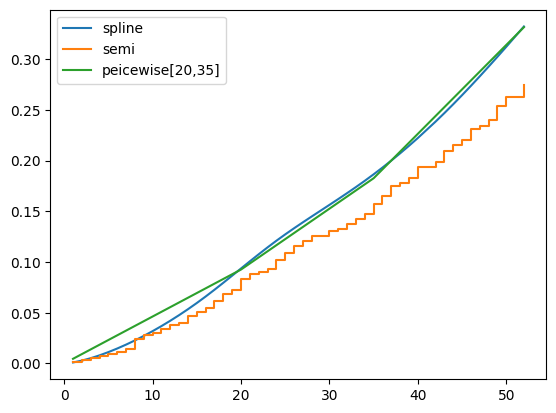

In [108]:
cph_semi = CoxPHFitter().fit(rossi, 'week', event_col='arrest')
cph_piecewise = CoxPHFitter(baseline_estimation_method="piecewise", breakpoints=[20, 35]).fit(rossi, 'week', event_col='arrest')

bch_key = "baseline cumulative hazard"

ax = cph_spline.baseline_cumulative_hazard_[bch_key].plot(label="spline")
cph_semi.baseline_cumulative_hazard_[bch_key].plot(ax=ax, drawstyle="steps-post", label="semi")
cph_piecewise.baseline_cumulative_hazard_[bch_key].plot(ax=ax, label="peicewise[20,35]")
plt.legend()

## Log-likelihood

In this author's opinion, the best way to measure predictive performance is evaluating the log-likelihood on out-of-sample data. The log-likelihood correctly handles any type of censoring, and is precisely what we are maximizing in the model training. The in-sample log-likelihood is available under `log_likelihood_` of any regression model. For out-of-sample data, the `score()` method (available on all regression models) can be used. This returns the *average evaluation of the out-of-sample log-likelihood*. We want to maximize this.

In [109]:
rossi_log = load_rossi().sample(frac=1.0)
train_rossi = rossi_log.iloc[:400]
test_rossi = rossi_log.iloc[400:]

cph_log_l2 = CoxPHFitter(penalizer=0.1, l1_ratio=0.).fit(train_rossi, 'week', 'arrest')
cph_log_l1 = CoxPHFitter(penalizer=0.1, l1_ratio=1.).fit(train_rossi, 'week', 'arrest')

print(cph_log_l2.score(test_rossi))
print(cph_log_l1.score(test_rossi)) # better model

-0.516047004014218
-0.5312631327060611


## Akaike information criterion (AIC)

For within-sample validation, the AIC is a great metric for comparing models as it relies on the log-likelihood. It's available under `AIC_` for parametric models, and `AIC_partial_` for Cox models (because the Cox model maximizes a *partial* log-likelihood, it can't be reliably compared to parametric model's AIC.)

In [110]:
cph_aic_l2 = CoxPHFitter(penalizer=0.1, l1_ratio=0.).fit(rossi, 'week', 'arrest')
cph_aic_l1 = CoxPHFitter(penalizer=0.1, l1_ratio=1.).fit(rossi, 'week', 'arrest')

print(cph_aic_l2.AIC_partial_) # lower is better
print(cph_aic_l1.AIC_partial_)

1339.5661657040805
1364.761303079606


## Concordance Index

Another censoring-sensitive measure is the concordance-index, also known as the c-index. This measure evaluates the accuracy of the *ranking* of predicted time. It is in fact a generalization of AUC, another common loss function, and is interpreted similarly:

* 0.5 is the expected result from random predictions,
* 1.0 is perfect concordance and,
* 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)

Fitted survival models typically have a concordance index between 0.55 and 0.75 (this may seem bad, but even a perfect model has a lot of noise than can make a high score impossible). In *lifelines*, a fitted model's concordance-index is present in the output of `score()`, but also available under the `concordance_index_` property. Generally, the measure is implemented in *lifelines* under `lifelines.utils.concordance_index` and accepts the actual times (along with any censored subjects) and the predicted times.

In [111]:
# method one
cph.print_summary()

# method two
print(cph.concordance_index_)

# method three
print(cph.score(rossi, scoring_method="concordance_index"))

# method four
from lifelines.utils import concordance_index
print(concordance_index(rossi['week'], -cph.predict_partial_hazard(rossi), rossi['arrest']))

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2023-03-13 06:13:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.38       0.68       0.19            -0.75            -0.00                 0.47                 1.00
age        -0.06       0.94       0.02            -0.10            -0.01                 0.90                 0.99
race        0.31       1.37       0.31            -0.29             0.92                 0.75                 2.50
wexp       -0.15       0.86       0.21            -0.57             0.27                 0.57                 1.30
mar        -0.43       0.65       0.38            -1.18             0.31                 0.31                 1.37
paro       -0.08       0.92       0.20            -0.47             0.30                 0.63                 1.35
prio        0.09       1.10       0.03             0.04             0.15                 1.04                 1.16

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -1.98   0.05       4.40
age           0.00 -2.61   0.01       6.79
race          0.00  1.02   0.31       1.70
wexp          0.00 -0.71   0.48       1.06
mar           0.00 -1.14   0.26       1.97
paro          0.00 -0.43   0.66       0.59
prio          0.00  3.19 <0.005       9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

0.6403292470997135
0.6403292470997135
0.6403292470997135


## Cross validation

*lifelines* has an implementation of k-fold cross validation under `lifelines.utils.k_fold_cross_validation`. This function accepts an instance of a regression fitter (either `lifelines.fitters.coxph_fitter.CoxPHFitter` of `lifelines.fitters.aalen_additive_fitter.AalenAdditiveFitter`), a dataset, plus `k` (the number of folds to perform, default 5). On each fold, it splits the data into a training set and a testing set fits itself on the training set and evaluates itself on the testing set (using the concordance measure by default).

In [112]:
from lifelines.datasets import load_regression_dataset
from lifelines.utils import k_fold_cross_validation

regression_dataset = load_regression_dataset()
scores = k_fold_cross_validation(cph, regression_dataset, 'T', event_col='E', k=3)
print(scores)
#[-2.9896, -3.08810, -3.02747]

scores = k_fold_cross_validation(cph, regression_dataset, 'T', event_col='E', k=3, scoring_method="concordance_index")
print(scores)
# [0.5449, 0.5587, 0.6179]

[-2.9616498949358894, -3.12871321533857, -3.222075044731406]
[0.5809842331581462, 0.5402521823472357, 0.5756218905472636]


## Model probability calibration

New in *lifelines* v0.24.11 is the `lifelines.calibration.survival_probability_calibration` function to measure your fitted survival model against observed frequencies of events. We follow the advice in "Graphical calibration curves and the integrated calibration index (ICI) for survival models" by P. Austin and co., and use create a smoothed calibration curve using a flexible spline regression model (this avoids the traditional problem of binning the continuous-valued probability, and handles censored data).

ICI =  0.003692605731450535
E50 =  0.003442100352938793


(<AxesSubplot:title={'center':'Smoothed calibration curve of \npredicted vs observed probabilities of t ≤ 25 mortality'}, xlabel='Predicted probability of \nt ≤ 25 mortality', ylabel='Observed probability of \nt ≤ 25 mortality'>,
 0.003692605731450535,
 0.003442100352938793)

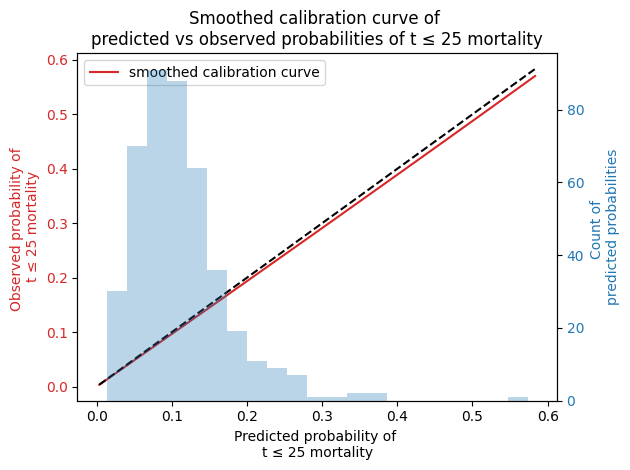

In [113]:
from lifelines.calibration import survival_probability_calibration

regression_dataset = load_rossi()
cph_reg = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=3)
cph_reg.fit(rossi, "week", "arrest")

survival_probability_calibration(cph_reg, rossi, t0=25)

## Prediction on censored subjects

A common use case is to predict the event time of censored subjects. This is easy to do, but we first have to calculate an important conditional probability. Let $T$ be the (random) event time for some subject, and $S(t)≔P(T > t)$ be their survival function. We are interested in answering the following: *What is a subject's new survival function given I know the subject has lived past time $s$?* Mathematically:

$$
\begin{align*}
P(T > t \;|\; T > s) &= \frac{P(T > t \;\text{and}\; T > s)}{P(T > s)} \\
                        &= \frac{P(T > t)}{P(T > s)} \\
                        &= \frac{S(t)}{S(s)}
\end{align*}
$$

Thus we scale the original survival function by the survival function at time $s$ (everything prior to $s$ should be mapped to 1.0 as well, since we are working with probabilities and we know that the subject was alive before $s$).

This is such a common calculation that *lifelines* has all this built in. The `conditional_after` kwarg in all prediction methods allows you to specify what $s4 is per subject. Below we predict the remaining life of censored subjects:

Text(0.5, 0, 'time $t$')

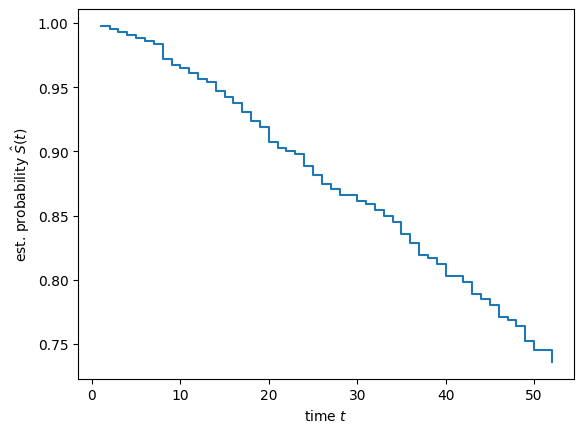

In [114]:
from sksurv.nonparametric import kaplan_meier_estimator

# Make arrest a boolean
rossi['arrest'] = rossi['arrest'].astype(bool)
time, survival_prob = kaplan_meier_estimator(rossi['arrest'], rossi['week'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability $\hat{S}(t)$")
plt.xlabel("time $t$")

In [115]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn",
            "sksurv": "scikit-survival"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

pandas==1.5.3
lifelines==0.27.4
matplotlib==3.4.3
numpy==1.24.2
